# Credit

All credit for this data and code belongs with **Stephen Thornquist**. He collected the data and wrote the code from which this notebook is adapted. Thank you Stephen!

Data was collected at Rockefeller University circa June 2025 in the lab of Gaby Maimon.

Any mistakes are due to Niko Schonsheck's meddling and should be attributed as such.

# Imports and functions

In [1]:
from typing import Any
from pathlib import Path
import numpy as np
from ripser import ripser
from matplotlib.axes import Axes
from matplotlib.collections import QuadMesh
import matplotlib.pyplot as plt
import seaborn as sns

## Helper functions

In [2]:
def to_phase(arr : np.ndarray) -> np.ndarray[Any, complex]:
    """
    Takes data of the form ROIs x time and returns a
    phase array of shape (time, ) whose complex angle
    corresponds to the "phase" of the data
    
    ## Arguments
    `arr` : `np.ndarray`
        Shape (n_rois, time)

    ## Returns

    `phase` : `np.ndarray`
        Shape (time,)

    """

    circ = np.exp(1j*np.linspace(-np.pi, np.pi, arr.shape[0]))

    # Because the EPGs in the bridge are actually split, this relationship
    # should be [0, 2, 4, 6, 8, ... 1, 3, 5, ...]
    circ = np.array(circ[::2].tolist() + circ[1::2].tolist())

    return circ @ arr

def plot_imaging_heatmap(time : np.ndarray, data : np.ndarray, ax : Axes) -> QuadMesh:
    """
    Plots the EPG imaging data in the standard convention: time axis on the x
    coordinate, EPG rois ordered on the vertical component, shading proportional
    to the ΔF/F

    ## Arguments

    - `time`
        The time axis of the data, x axis, of shape `(time,)`

    - `data`
        The fluorescence data itself, of shape `(n_rois, time)`

    - `ax`
        The matplotlib `Axes` on which to plot.

    ## Returns

    - `pcolor : QuadMesh`
        The output of the `pcolormesh` call that produces the heatmap
    """

    # modify the array `time` so that each pixel is centered on its appropriate timepoint
    time = time.astype(float)
    time[1:] -= np.diff(time)/2
    time[0] -= np.mean(np.diff(time))/2
    time = np.insert(time, 0, time[0] - np.mean(np.diff(time)))

    xx, yy = np.meshgrid(time, np.linspace(-np.pi, np.pi, data.shape[0] + 1))

    pc = ax.pcolormesh(
        xx, yy, data,
        cmap = 'Blues', vmin = 0, vmax = 2.0
    )

    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    return pc

def plot_phase_and_heading(image_timestamps : np.ndarray,
                           phase : np.ndarray,
                           vr_timestamps : np.ndarray,
                           vr_heading : np.ndarray,
                           ax : Axes,
                           subtract_offset : bool = True,
                           ) -> None:
    
    # subtract out the offset between the phase
    # and the VR heading so that they overlay
    # (the offset is arbitrary from fly to fly)
    if subtract_offset:
        # upsample to the vr timestamp positions
        phase_interp = np.exp(1j*np.interp(
            vr_timestamps,
            image_timestamps,
            np.unwrap(np.angle(phase)),
        ))
        offset = np.mean(phase_interp / np.exp(1j*vr_heading))
        phase /= offset

    ax.plot(
        vr_timestamps,
        vr_heading,
        'o',
        markersize = 1,
        color = '#000000',
        label = 'VR heading',
    )

    ax.plot(
        image_timestamps,
        np.angle(phase),
        'o',
        markersize = 1,
        label = 'EPG phase'
    )

    ax.legend(
        loc = 'upper right',
        fontsize = 8,
        markerscale = 2,
    )
    pass

In [3]:
def plot_n_longest_bars(array, n, title = None):
    # Sort the array based on the width of the bars (x_end - x_start)
    sorted_array = sorted(array, key=lambda x: x[1] - x[0], reverse=True)
    
    # Take the first n rows from the sorted array
    n_longest_bars = sorted_array[:n]

    # Sort by birthtime
    n_longest_bars = sorted(n_longest_bars, key = lambda x: x[0], reverse = True)
    
    # Create a figure and axis
    fig, ax = plt.subplots()
    
    # Plot each of the n longest bars
    for i in range(len(n_longest_bars)):
        x_start, x_end = n_longest_bars[i]
        width = x_end - x_start
        ax.hlines(i, x_start, x_end, linewidth=5, color='black')
    
    # Set plot limits and labels
    # ax.set_xlim(0, 1)
    ax.set_ylim(-1, len(n_longest_bars))
    ax.set_xlabel('')
    ax.set_title('')
    
    # Hide y-axis ticks and labels
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    # Hide x-axis ticks and labels
    # ax.set_xticks([])
    # ax.set_xticklabels([])
    
    # Show grid lines
    ax.grid(True, axis='x', linestyle='--', linewidth=0.5, alpha=0.5, color='gray')
    
    # plt.xticks(np.arange(0, 1.1, 0.1))

    ax.set_title(title)
    
    # Show the plot
    plt.show()


# Load and explore data

In [4]:
file_dict = np.load('data_files/Fly_1/imaging_data.npz', allow_pickle=False)

In [5]:
# See keys
file_dict.keys()

KeysView(NpzFile 'data_files/Fly_1/imaging_data.npz' with keys: dfof, image_timestamps, vr_heading, vr_timestamps, vr_position...)

In [6]:
# Get flourescence
# ΔF/F data in ROI x time format
dfof = file_dict['dfof']

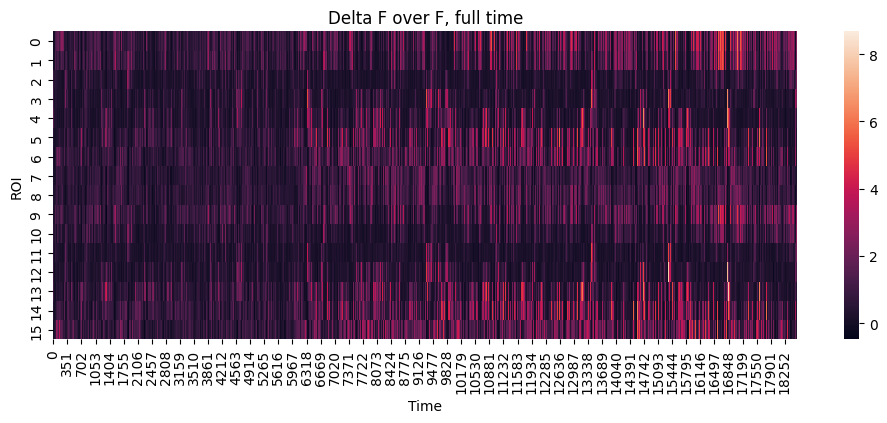

In [7]:
# Plot flourescence

fig, ax = plt.subplots(figsize = (12, 4))

sns.heatmap(dfof, ax = ax)

ax.set_ylabel('ROI')
ax.set_xlabel('Time')

ax.set_title('Delta F over F, full time')

plt.show()

In [8]:
# Timestamps of each frame in epoch time
image_timestamps = file_dict['image_timestamps']

In [9]:
# Info about the VR


# Orientation in VR space of the imaged fly
vr_heading = file_dict['vr_heading']
# Timestamps of the behavior data
vr_timestamps = file_dict['vr_timestamps']
# VR position in x, y space as a complex number (x + iy)
# not used here but you can if you want!
vr_position = file_dict['vr_position'] #noqa
# Timestamp of the moment the visual environment is activated
vr_on_time = file_dict['bar_on_time']

In [10]:
# Separate views of the data only where the VR is off and
# the VR is on
dfof_pre_vr, dfof_during_vr = (
    np.take(dfof, np.where(image_timestamps < vr_on_time)[0], axis = -1),
    np.take(dfof, np.where(image_timestamps >= vr_on_time)[0], axis = -1),
)


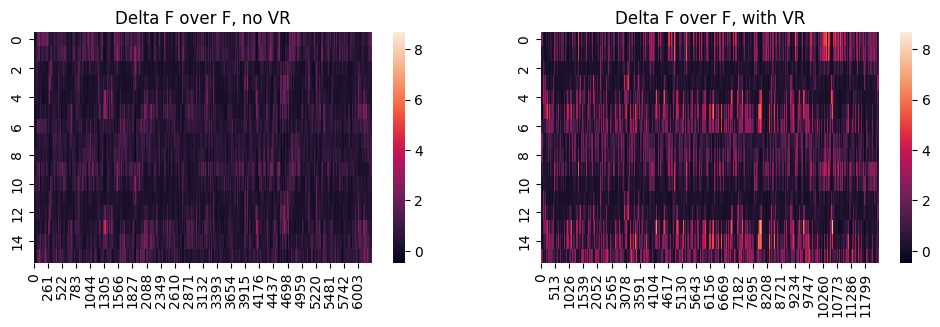

In [11]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 3))

vmin = np.min(dfof)
vmax = np.max(dfof)

sns.heatmap(dfof_pre_vr, ax = ax[0], vmin = vmin, vmax = vmax)
ax[0].set_title('Delta F over F, no VR')

sns.heatmap(dfof_during_vr, ax = ax[1], vmin = vmin, vmax = vmax)
ax[1].set_title('Delta F over F, with VR')

plt.show()

# Do topology!

In [12]:
# Downsample and transpose for Ripser

downsample_by = 6

pop_activity_during_VR_transposed = dfof_during_vr.T[::downsample_by]

In [13]:
# Do Ripser computation

ripser_result_1 = ripser(pop_activity_during_VR_transposed)
barcode_result_1 = ripser_result_1['dgms'][1]

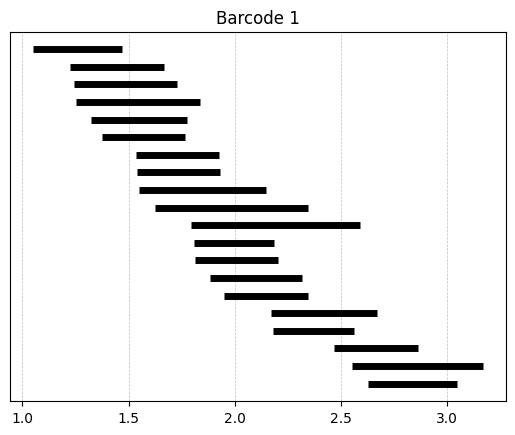

In [14]:
# Plot the barcode - we expect one long bar. It should be obvious!
plot_n_longest_bars(barcode_result_1, 20, title = 'Barcode 1')

# What happened?

The activity of these cells is modulated not only by heading direction, but speed and angular velocity

In [15]:
# Let's normalize each row by its mean
normalized_pop_activity_during_VR_transposed = pop_activity_during_VR_transposed.copy()

for row_index in range(normalized_pop_activity_during_VR_transposed.shape[0]):
    row_mean = np.mean(normalized_pop_activity_during_VR_transposed[row_index, :])
    normalized_pop_activity_during_VR_transposed[row_index, :] -= row_mean

In [16]:
# Then we'll use cosine distance

ripser_result_2 = ripser(normalized_pop_activity_during_VR_transposed, metric = 'cosine')
barcode_result_2 = ripser_result_2['dgms'][1]

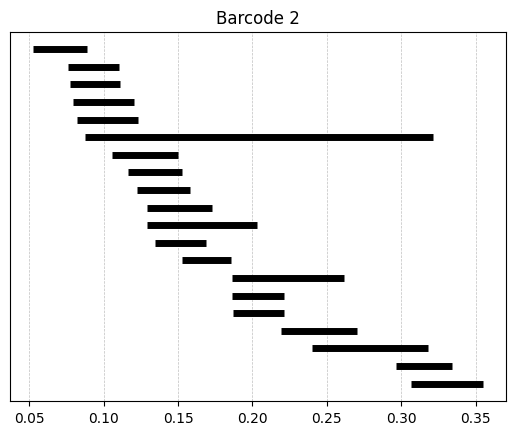

In [17]:
# Plot the barcode 
plot_n_longest_bars(barcode_result_2, 20, title = 'Barcode 2')

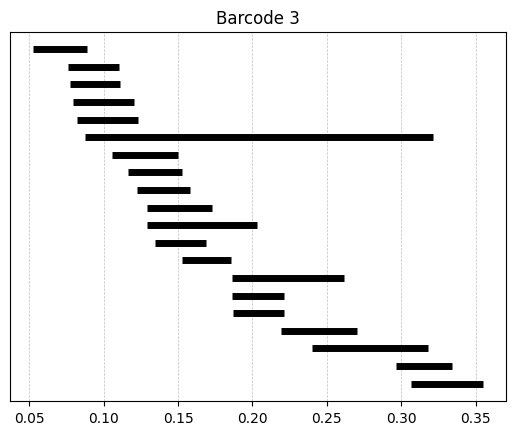

In [18]:
# This can also be done in one step:

ripser_result_3 = ripser(pop_activity_during_VR_transposed, metric = 'correlation')
barcode_result_3 = ripser_result_3['dgms'][1]
plot_n_longest_bars(barcode_result_3, 20, title = 'Barcode 3')

In [19]:
# Check that we in fact have the exact same barcodes 

assert(np.array_equal(barcode_result_2, barcode_result_3))

# Did we cheat?

Let's make sure the big bar is NOT there if we destroy the temporal structure and recompute with 'correlation' metric.

In [20]:
shuffled_pop_activity_during_VR_transposed = np.zeros(pop_activity_during_VR_transposed.shape)

# Shuffle each column, i.e., the time series of each nenuron
for col_index in range(16):
    column = pop_activity_during_VR_transposed[:, col_index].copy()
    np.random.shuffle(column)
    shuffled_pop_activity_during_VR_transposed[:, col_index] = column

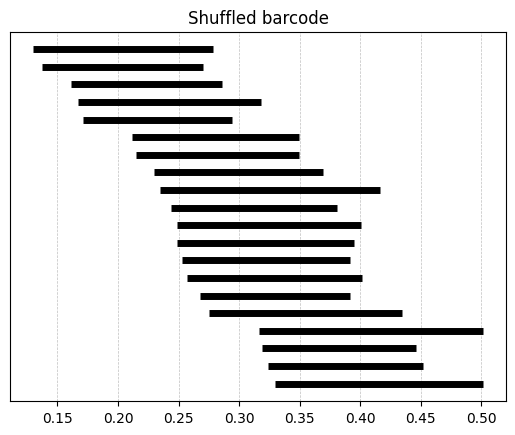

In [21]:
# Redo Ripser calculation
shuffled_ripser_result = ripser(shuffled_pop_activity_during_VR_transposed, metric = 'correlation')
shuffled_barcode = shuffled_ripser_result['dgms'][1]
plot_n_longest_bars(shuffled_barcode, 20, title = 'Shuffled barcode')